In [ ]:
# IMU_DATA: orientation_z, orientation_w, angular_velocity_z, linear_acceleration_z
import csv
import numpy as np
import utm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation, PillowWriter
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class KF_SensorFusion:
    def __init__(self, gps_csv_file, imu_csv_file):
        self.gps_csv_file = gps_csv_file
        self.imu_csv_file = imu_csv_file
        self.gps_data = []
        self.imu_data = []
        self.utm_data = []

    def load_data_from_csv(self, filename, has_header=True):
        data = []
        with open(filename, newline='') as csvfile:
            reader = csv.reader(csvfile)
            if has_header:
                next(reader)  # Skip header row
            for row in reader:
                data.append(row)
        return data

    def load_data(self):
        self.gps_data = self.load_data_from_csv(self.gps_csv_file)
        self.imu_data = self.load_data_from_csv(self.imu_csv_file)

    def gps_to_modified_utm(self):
        '''Converts GPS data to UTM coordinates and includes altitude data.'''
        initial_easting = None
        initial_northing = None

        for entry in self.gps_data:
            time, lat_str, lon_str, alt_str = entry
            if 'nan' in lat_str.lower() or 'nan' in lon_str.lower() or 'nan' in alt_str.lower():
                continue

            lat = float(lat_str)
            lon = float(lon_str)
            alt = float(alt_str)

            # Convert latitude and longitude to UTM coordinates
            easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)

            # If this is the first valid entry, store its easting and northing as the initial offset
            if initial_easting is None or initial_northing is None:
                initial_easting = easting
                initial_northing = northing

            # Subtract the initial offset to make the first point (0,0)
            adjusted_easting = easting - initial_easting
            adjusted_northing = northing - initial_northing

            # Format: ([UTM Format], altitude)
            self.utm_data.append({'time': float(time), 'easting': adjusted_easting, 'northing': adjusted_northing, 'zone_number': zone_number, 'zone_letter': zone_letter, 'altitude': alt })

    @staticmethod ##need to update this function based on time for valid index 
    def compute_imu_biases(gps_data, imu_data):
        first_valid_index = next((i for i, entry in enumerate(gps_data) if 'nan' not in entry[1].lower()), None)
        if first_valid_index is None:
            print("Warning: No valid GPS data found. Cannot compute IMU biases.")
            return None, None
        print(f"First valid GPS entry index: {first_valid_index}")
        stationary_imu_data = imu_data[:first_valid_index]
        angular_velocity_data = [np.array([float(entry[5]), float(entry[6]), float(entry[7])]) for entry in stationary_imu_data]
        linear_acceleration_data = [np.array([float(entry[8]), float(entry[9]), float(entry[10])]) for entry in stationary_imu_data]
        angular_velocity_bias = np.mean(angular_velocity_data, axis=0)
        linear_acceleration_bias = np.mean(linear_acceleration_data, axis=0)
        print(f"Computed Angular Velocity Bias: {angular_velocity_bias}")
        print(f"Computed Linear Acceleration Bias: {linear_acceleration_bias}")
        return angular_velocity_bias, linear_acceleration_bias, first_valid_index
# MAVROS
    def unbias_imu_data(self, angular_velocity_bias, linear_acceleration_bias):
        unbias_imu_data = []
        for entry in self.imu_data:
            # Extract angular velocity and linear acceleration from IMU data
            angular_velocity = np.array([float(entry[5]), float(entry[6]), float(entry[7])])
            linear_acceleration = np.array([float(entry[8]), float(entry[9]), float(entry[10])])

            # Subtract biases from angular velocity and linear acceleration
            unbias_angular_velocity = angular_velocity - angular_velocity_bias
            unbias_linear_acceleration = linear_acceleration - linear_acceleration_bias

            # Extract quaternion components from IMU data
            x, y, z, w = float(entry[1]), float(entry[2]), float(entry[3]), float(entry[4])
            
            # Convert quaternion to Euler angles
            roll, pitch, yaw = self.quaternion_to_euler(x, y, z, w)

            # Create an unbias entry with Euler angles
            unbias_entry = entry[:1] + [roll, pitch, yaw] + unbias_angular_velocity.tolist() + unbias_linear_acceleration.tolist() + entry[11:]
            unbias_imu_data.append(unbias_entry)
        # Print the first two entries to check if the data is stored well
        print("First two entries in unbias_imu_data:")
        for i in range(2):
            print(unbias_imu_data[i])
        self.unbias_imu_data = unbias_imu_data

    def combine_sensor_data(self):
        """Combine GPS and IMU data and sort by timestamp, adding an index to each entry."""
        combined_data = []
        for gps_entry in self.utm_data:
            time = float(gps_entry['time'])
            combined_data.append(('GPS', time, gps_entry))
        for imu_entry in self.unbias_imu_data:
            time = float(imu_entry[0])  
            combined_data.append(('IMU', time, imu_entry))
        combined_data.sort(key=lambda x: x[1])
        self.indexed_sensor_data = [(i, *data) for i, data in enumerate(combined_data)]
        # Print the first GPS and IMU entry
        gps_printed = imu_printed = False
        for entry in self.indexed_sensor_data:
            if entry[1] == 'GPS' and not gps_printed:
                print("First GPS Entry:", entry)
                gps_printed = True
            elif entry[1] == 'IMU' and not imu_printed:
                print("First IMU Entry:", entry)
                imu_printed = True
            if gps_printed and imu_printed:
                break
            
    #take this function from internet as its standard function
    def quaternion_to_euler(self, x, y, z, w):
        """
        Convert a quaternion to Euler angles (roll, pitch, yaw).

        Parameters:
        x, y, z, w (float): Quaternion components.

        Returns:
        tuple: A tuple containing roll, pitch, yaw angles in radians.
        """
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)

        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if abs(sinp) >= 1:
            pitch = np.pi / 2 * np.sign(sinp)  # Use 90 degrees if out of range
        else:
            pitch = np.arcsin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)
        return roll, pitch, yaw

    def compute_stationary_orientation(self, first_valid_index):
        """
        Compute the average orientation of the IMU when the car is stationary
        and plot the IMU frame.
        """
        stationary_imu_data = self.unbias_imu_data[:first_valid_index]

        # Calculate average roll, pitch, yaw
        avg_roll = np.mean([entry[1] for entry in stationary_imu_data])
        avg_pitch = np.mean([entry[2] for entry in stationary_imu_data])
        avg_yaw = np.mean([entry[3] for entry in stationary_imu_data])

        return avg_roll, avg_pitch, avg_yaw

    def euler_to_rotation_matrix(self, roll, pitch, yaw):
        Rx = np.array([
            [1, 0, 0],
            [0, np.cos(roll), -np.sin(roll)],
            [0, np.sin(roll), np.cos(roll)]
        ])
        Ry = np.array([
            [np.cos(pitch), 0, np.sin(pitch)],
            [0, 1, 0],
            [-np.sin(pitch), 0, np.cos(pitch)]
        ])
        Rz = np.array([
            [np.cos(yaw), -np.sin(yaw), 0],
            [np.sin(yaw), np.cos(yaw), 0],
            [0, 0, 1]
        ])
        R = Rz @ Ry @ Rx
        return R

    def plot_imu_frame(self, roll, pitch, yaw):
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        axis_limit = 1.0
        ax.set_xlim([-axis_limit, axis_limit])
        ax.set_ylim([-axis_limit, axis_limit])
        ax.set_zlim([-axis_limit, axis_limit])
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        R = self.euler_to_rotation_matrix(roll, pitch, yaw)
        # Original IMU frame axes (before rotation)
        imu_axes = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
        rotated_axes = R @ imu_axes
        ax.quiver(0, 0, 0, rotated_axes[0, 0], rotated_axes[0, 1], rotated_axes[0, 2], length=0.1, color='red')
        ax.quiver(0, 0, 0, rotated_axes[1, 0], rotated_axes[1, 1], rotated_axes[1, 2], length=0.1, color='green')
        ax.quiver(0, 0, 0, rotated_axes[2, 0], rotated_axes[2, 1], rotated_axes[2, 2], length=0.1, color='blue')
        plt.title(f"IMU Orientation - Roll: {np.degrees(roll):.2f}, Pitch: {np.degrees(pitch):.2f}, Yaw: {np.degrees(yaw):.2f}")
        plt.show()
        
    def plot_gps_data(self):
        eastings = [data['easting'] for data in self.utm_data]
        northings = [data['northing'] for data in self.utm_data]
        plt.figure(figsize=(10, 6))
        plt.scatter(eastings, northings, c='blue', marker='o', label='raw GPS Points', s=3)  
        plt.title('GPS Data(raw) Scatter Plot')
        plt.xlabel('Easting')
        plt.ylabel('Northing')
        plt.legend()
        plt.grid(True)
        plt.show()

    #kalman filter functions for fusing IMU and GPS data
    def get_state_transition_matrix(self, dt):
        """Return the state transition matrix F based on the time difference dt."""
        # now: x, y, z, 
        #               roll, pitch, yaw, 
        #                           v_x, v_y, v_z, 
        #                                       angular_x, angular_y, angular_z,
        #                                                   a_x, a_y, a_z
        F = np.array([
            [1, 0, 0,   0, 0, 0,    dt, 0, 0,   0, 0, 0,    0.5 * dt**2, 0, 0],     # x = x + v_x*dt + 0.5*a_x*dt^2
            [0, 1, 0,   0, 0, 0,    0, dt, 0,   0, 0, 0,    0,  0.5 * dt**2, 0],    # y = y + v_y*dt + 0.5*a_y*dt^2
            [0, 0, 1,   0, 0, 0,    0, 0, dt,   0, 0, 0,    0,  0, 0.5 * dt**2],    # z = z + v_z*dt + 0.5*a_z*dt^2
            [0, 0, 0,   1, 0, 0,    0, 0, 0,    dt, 0, 0,   0, 0, 0],               # roll = roll + angular_x*dt
            [0, 0, 0,   0, 1, 0,    0, 0, 0,    0, dt, 0,   0, 0, 0],               # pitch = pitch + angular_y*dt
            [0, 0, 0,   0, 0, 1,    0, 0, 0,    0, 0, dt,   0, 0, 0],               # yaw = yaw + angular_z*dt
            [0, 0, 0,   0, 0, 0,    1, 0, 0,    0, 0, 0,    dt, 0, 0],              # v_x = v_x + a_x*dt
            [0, 0, 0,   0, 0, 0,    0, 1, 0,    0, 0, 0,    0, dt, 0],              # v_y = v_y + a_y*dt
            [0, 0, 0,   0, 0, 0,    0, 0, 1,    0, 0, 0,    0, 0, dt],              # v_z = v_z + a_z*dt
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    1, 0, 0,    0, 0, 0],              # angular_x = angular_x (constant angular velocity assumed)
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 1, 0,    0, 0, 0],              # angular_y = angular_y (constant angular velocity assumed)
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 1,    0, 0, 0],              # angular_z = angular_z (constant angular velocity assumed)
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    1, 0, 0],              # a_x = a_x (constant acceleration assumed)
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 1, 0],              # a_y = a_y (constant acceleration assumed)
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 1],              # a_z = a_z (constant acceleration assumed)
        ])
        return F

    def get_process_noise_covariance_matrix(self, dt):
        """Define the process noise covariance matrix Qt based on dt."""
        position_noise = 5 * dt
        orientation_noise = 0.05 * dt
        velocity_noise = 1 * dt
        angular_velocity_noise = 0.1 * dt
        acceleration_noise = 2 * dt

        Qt = np.diag([
            position_noise,        # x 
            position_noise,        # y 
            position_noise,        # z 
            orientation_noise,     # roll 
            orientation_noise,     # pitch 
            orientation_noise,     # yaw 
            velocity_noise,        # v_x 
            velocity_noise,        # v_y 
            velocity_noise,        # v_z 
            angular_velocity_noise,# angular_x
            angular_velocity_noise,# angular_y
            angular_velocity_noise,# angular_z
            acceleration_noise,    # a_x 
            acceleration_noise,    # a_y 
            acceleration_noise     # a_z 
        ])
        return Qt

    def predict_covariance(self, Pt, F, Qt):
        """Predict the next covariance matrix P(t+1)."""
        P_next = np.dot(np.dot(F, Pt), F.T) + Qt
        return P_next
    
    def get_gps_observation_matrix(self):
        """Return the GPS observation matrix H_GPS."""
        H_GPS = np.array([
            [1, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],   # X measurement affects the X position state
            [0, 1, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],   # Y measurement affects the Y position state
            [0, 0, 1,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0]    # Z measurement affects the Z position state
        ])
        return H_GPS
    
    def get_imu_observation_matrix(self):
        """Return the IMU observation matrix H_IMU."""
        H_IMU = np.array([
            [1, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures X
            [0, 1, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Y
            [0, 0, 1,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Z
            [0, 0, 0,   1, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Roll
            [0, 0, 0,   0, 1, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Pitch
            [0, 0, 0,   0, 0, 1,    0, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Yaw
            [0, 0, 0,   0, 0, 0,    1, 0, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Vx
            [0, 0, 0,   0, 0, 0,    0, 1, 0,    0, 0, 0,    0, 0, 0],  # IMU measures Vy
            [0, 0, 0,   0, 0, 0,    0, 0, 1,    0, 0, 0,    0, 0, 0],  # IMU measures Vz
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    1, 0, 0,    0, 0, 0],  # IMU measures angular_x
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 1, 0,    0, 0, 0],  # IMU measures angular_y
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 1,    0, 0, 0],  # IMU measures angular_z
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    1, 0, 0],  # IMU measures acceleration_x
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 1, 0],  # IMU measures acceleration_y
            [0, 0, 0,   0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 1],  # IMU measures acceleration_z
        ])
        return H_IMU

    def get_gps_measurement_noise_covariance_matrix(self):
        """Return the GPS measurement noise covariance matrix R_GPS."""
        gps_position_noise_variance = 3
        R_GPS = np.diag([gps_position_noise_variance, gps_position_noise_variance, gps_position_noise_variance])
        return R_GPS

    def get_imu_measurement_noise_covariance_matrix(self):
        """Return the IMU measurement noise covariance matrix R_IMU."""
        position_noise_variance = 50
        velocity_noise_variance = 10 
        roll_noise_variance = 0.05       
        pitch_noise_variance = 0.05       
        yaw_noise_variance = 0.05       
        angular_velocity_noise_variance = 0.1
        linear_acceleration_noise_variance = 100

        R_IMU = np.diag([
            position_noise_variance,     # X 
            position_noise_variance,     # Y 
            position_noise_variance,     # Z 
            roll_noise_variance,         # roll 
            pitch_noise_variance,        # pitch 
            yaw_noise_variance,          # yaw
            velocity_noise_variance,     # Vx 
            velocity_noise_variance,     # Vy 
            velocity_noise_variance,     # Vz 
            angular_velocity_noise_variance, # angular_x
            angular_velocity_noise_variance, # angular_y
            angular_velocity_noise_variance, # angular_z 
            linear_acceleration_noise_variance, # a_x 
            linear_acceleration_noise_variance,  # a_y 
            linear_acceleration_noise_variance  # a_z 
        ])
        return R_IMU

    def calculate_kalman_gain(self, P_next, H, R):
        # Intermediate matrix calculation
        intermediate_matrix = np.dot(np.dot(H, P_next), H.T) + R
        # Calculating the Kalman Gain
        K_next = np.dot(np.dot(P_next, H.T), np.linalg.inv(intermediate_matrix))
        return K_next

    def run_kalman_filter(self):
        """Run the Kalman Filter to fuse IMU and GPS data for pose estimation."""
        # Initial state [x, y, z, roll, pitch, yaw, v_x, v_y, v_z, angular_x, angular_y, angular_z, a_x, a_y, a_z]
        xt = np.array([0, 0, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0])

        # Initial covariance matrix
        Pt = np.array([
                        [1000, 0, 0,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # x
                        [0, 1000, 0,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # y
                        [0, 0, 1000,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # z
                        [0, 0, 0,        100, 0, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # roll
                        [0, 0, 0,        0, 100, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # pitch
                        [0, 0, 0,        0, 0, 100,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # yaw
                        [0, 0, 0,        0, 0, 0,     100, 0, 0,    0, 0, 0,    0, 0, 0],       # v_x
                        [0, 0, 0,        0, 0, 0,     0, 100, 0,    0, 0, 0,    0, 0, 0],       # v_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 100,    0, 0, 0,    0, 0, 0],       # v_z
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    100, 0, 0,    0, 0, 0],       # angular_x
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 100, 0,    0, 0, 0],       # angular_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 100,    0, 0, 0],       # angular_z
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      1000, 0, 0],    # a_x
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      0, 1000, 0],    # a_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      0, 0, 1000],    # a_z
                    ])
        I = np.eye(15)

        # Create a list to store the state (X, Y, Z, roll, pitch, yaw)
        sf_KF_state = [(xt[0], xt[1], xt[2], xt[3], xt[4], xt[5])]  # Storing initial state
        gps_started = False  
        for i, (index, sensor_type, time, sensor_data) in enumerate(self.indexed_sensor_data):
            # # Start processing only when the first GPS data is encountered
            if sensor_type == 'GPS' and not gps_started:
                gps_started = True
                previous_time = time  # Initialize previous_time with the first GPS time
            if not gps_started:
                continue  # Skip until first GPS data is encountered
            # Calculate dt
            dt = time - previous_time if previous_time is not None else 0

            # Prediction step for both GPS and IMU
            F = self.get_state_transition_matrix(dt)
            Qt = self.get_process_noise_covariance_matrix(dt)
            xt = np.dot(F, xt)   # State prediction
            Pt = self.predict_covariance(Pt, F, Qt)  # Covariance prediction

            # Update step based on sensor type
            if sensor_type == 'GPS':
                H_GPS = self.get_gps_observation_matrix()
                R_GPS = self.get_gps_measurement_noise_covariance_matrix()
                Zt_GPS = [sensor_data['easting'], sensor_data['northing'], sensor_data['altitude']]  # Extracting GPS measurements
                Kt = self.calculate_kalman_gain(Pt, H_GPS, R_GPS)
                y = Zt_GPS - np.dot(H_GPS, xt)
                # State update
                xt = xt + np.dot(Kt,y)
                # Covariance update
                Pt = np.dot(I - np.dot(Kt, H_GPS), Pt)
                
            elif sensor_type == 'IMU':
                # Dead reckoning for IMU data (integration of velocity and position)
                ax = sensor_data[7]
                ay = sensor_data[8]
                az = sensor_data[9]
                Vx = xt[6] + ax * dt  # Vx = Vx + ax*dt
                Vy = xt[7] + ay * dt  # Vy = Vy + ay*dt
                Vz = xt[8] + az * dt  # Vz = Vz + az*dt
                X = xt[0] + Vx * dt  # X = X + Vx*dt
                Y = xt[1] + Vy * dt  # Y = Y + Vy*dt
                Z = xt[2] + Vz * dt  # Y = Y + Vy*dt
                roll = sensor_data[1]
                pitch = sensor_data[2]
                yaw = sensor_data[3]
                ang_x = sensor_data[4]
                ang_y = sensor_data[5]
                ang_z = sensor_data[6]

                Zt_IMU = [X, Y, Z, roll, pitch, yaw, Vx, Vy, Vz, ang_x, ang_y, ang_z, ax, ay, az]  # IMU measurements
                H_IMU = self.get_imu_observation_matrix()
                R_IMU = self.get_imu_measurement_noise_covariance_matrix()
                Kt = self.calculate_kalman_gain(Pt, H_IMU, R_IMU)
                y = np.array(Zt_IMU) - np.dot(H_IMU, xt)
                xt = xt + np.dot(Kt, y)
                Pt = np.dot(I - np.dot(Kt, H_IMU), Pt)

            sf_KF_state.append((xt[0], xt[1], xt[2], xt[3], xt[4], xt[5]))  # Append updated state (X, Y, Z, Roll, Pitch, Yaw)
            previous_time = time  # Update previous time
        return sf_KF_state

    def run_dead_reckoning_for_IMU(self):
        """Run dead reckoning to generate IMU estimates."""
        # Initial state and covariance

        # [x, y, z, roll, pitch, yaw, v_x, v_y, v_z, angular_x, angular_y, angular_z, a_x, a_y, a_z]
        xt = np.array([0, 0, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0,    0, 0, 0])
        Pt = np.array([
                        [1000, 0, 0,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # x
                        [0, 1000, 0,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # y
                        [0, 0, 1000,     0, 0, 0,       0, 0, 0,    0, 0, 0,    0, 0, 0],       # z
                        [0, 0, 0,        100, 0, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # roll
                        [0, 0, 0,        0, 100, 0,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # pitch
                        [0, 0, 0,        0, 0, 100,     0, 0, 0,    0, 0, 0,    0, 0, 0],       # yaw
                        [0, 0, 0,        0, 0, 0,     100, 0, 0,    0, 0, 0,    0, 0, 0],       # v_x
                        [0, 0, 0,        0, 0, 0,     0, 100, 0,    0, 0, 0,    0, 0, 0],       # v_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 100,    0, 0, 0,    0, 0, 0],       # v_z
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    100, 0, 0,    0, 0, 0],       # angular_x
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 100, 0,    0, 0, 0],       # angular_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 100,    0, 0, 0],       # angular_z
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      1000, 0, 0],    # a_x
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      0, 1000, 0],    # a_y
                        [0, 0, 0,        0, 0, 0,     0, 0, 0,    0, 0, 0,      0, 0, 1000],    # a_z
                    ])
        I = np.eye(15)  # 8x8 Identity matrix

        # List to store dead-reckoned IMU estimates
        deadreckoned_IMU_estimates = []
# unbias_entry = entry[:1] + [roll, pitch, yaw] + unbias_angular_velocity.tolist() + unbias_linear_acceleration.tolist() + entry[11:]             
        previous_time = None
        for i, (index, sensor_type, time, sensor_data) in enumerate(self.indexed_sensor_data):
            if sensor_type != 'IMU':
                continue  # Process only IMU data

            # Calculate dt
            dt = time - previous_time if previous_time is not None else 0

            # Prediction step for IMU
            F = self.get_state_transition_matrix(dt)
            Qt = self.get_process_noise_covariance_matrix(dt)
            xt = np.dot(F, xt)   # State prediction
            Pt = self.predict_covariance(Pt, F, Qt)  # Covariance prediction

            # Dead reckoning for IMU data
            ax = sensor_data[7]
            ay = sensor_data[8]
            az = sensor_data[9]
            Vx = xt[6] + ax * dt  # Vx = Vx + ax*dt
            Vy = xt[7] + ay * dt  # Vy = Vy + ay*dt
            Vz = xt[8] + az * dt  # Vz = Vz + az*dt
            X = xt[0] + Vx * dt  # X = X + Vx*dt
            Y = xt[1] + Vy * dt  # Y = Y + Vy*dt
            Z = xt[2] + Vz * dt  # Y = Y + Vy*dt
            roll = sensor_data[1]
            pitch = sensor_data[2]
            yaw = sensor_data[3]
            ang_x = sensor_data[4]
            ang_y = sensor_data[5]
            ang_z = sensor_data[6]
            Zt_IMU = [X, Y, Z, roll, pitch, yaw, Vx, Vy, Vz, ang_x, ang_y, ang_z, ax, ay, az]  # IMU measurements

            H_IMU = self.get_imu_observation_matrix()
            R_IMU = self.get_imu_measurement_noise_covariance_matrix()
            Kt = self.calculate_kalman_gain(Pt, H_IMU, R_IMU)
            y = np.array(Zt_IMU) - np.dot(H_IMU, xt)
            xt = xt + np.dot(Kt, y)
            Pt = np.dot(I - np.dot(Kt, H_IMU), Pt)

            deadreckoned_IMU_estimates.append((xt[0], xt[1], xt[2], xt[3], xt[4], xt[5]))  # Append updated state (X, Y, Theta)
            previous_time = time  # Update previous time

        return deadreckoned_IMU_estimates


    #### Visualization functions ####

    def plot_kf_states_2d(self, sf_KF_state):
        """Plot the estimated states from the Kalman Filter against GPS data."""
        X = [state[0] for state in sf_KF_state]
        Y = [state[1] for state in sf_KF_state]
        # Extracting Easting and Northing from GPS data
        eastings = [data['easting'] for data in self.utm_data]
        northings = [data['northing'] for data in self.utm_data]
        plt.figure(figsize=(12, 6))
        # Plot Estimated Trajectory (X, Y) and GPS data (translated Easting, translated Northing)
        plt.scatter(X, Y, label='Estimated Trajectory (X, Y)', marker='o', s=1)
        plt.scatter(eastings, northings, label='GPS Data (Easting, Northing)', marker='o', s=0.5)
        plt.xlabel('X / Easting')
        plt.ylabel('Y / Northing')
        plt.title('Estimated Trajectory and GPS Data')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def animate_kf_states_2d(self, sf_KF_state, save_path='kf_animation.mp4', skip_rate=200):
        """Animate the estimated states from the Kalman Filter against GPS data."""
        X = np.array([state[0] for state in sf_KF_state])
        Y = np.array([state[1] for state in sf_KF_state])
        
        eastings = np.array([data['easting'] for data in self.utm_data])
        northings = np.array([data['northing'] for data in self.utm_data])

        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_title('Estimated Trajectory and GPS Data')
        ax.set_xlabel('X / Easting')
        ax.set_ylabel('Y / Northing')
        ax.set_xlim(-5000, 5000)
        ax.set_ylim(-5000, 5000)
        ax.grid(True)

        est_line, = ax.plot([], [], '-', color='blue', linewidth=1.5, label='Estimated Trajectory')
        gps_line, = ax.plot([], [], 'o', color='red', markersize=0.1, alpha=0.2, label='GPS Data')
        ax.legend()

        num_frames = len(X)//skip_rate

        def init():
            est_line.set_data([], [])
            gps_line.set_data([], [])
            return est_line, gps_line

        def update(frame):
            idx = frame * skip_rate
            
            print(f"Rendering frame {frame}/{num_frames}", end='\r')
            est_line.set_data(X[:idx], Y[:idx])
            gps_line.set_data(eastings[:idx], northings[:idx])
            return est_line, gps_line


        ani = animation.FuncAnimation(
            fig, update, frames=num_frames, init_func=init,
            interval=1, blit=True, repeat=False
        )

        ani.save(save_path, fps=30, dpi=150)
        plt.close(fig)
        
    def plot_kf_states_3d(self, sf_KF_state):
        """Plot the estimated states from the Kalman Filter against GPS data."""
        # Estimatated States
        X = [state[0] for state in sf_KF_state]
        Y = [state[1] for state in sf_KF_state]
        Z = [state[2] for state in sf_KF_state]
        
        # GPS data
        eastings = [data['easting'] for data in self.utm_data]
        northings = [data['northing'] for data in self.utm_data]
        altitude = [data['altitude'] for data in self.utm_data]
        
        # Plotting
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(X, Y, Z, label='KF Estimated Path', color='blue')
        ax.plot(eastings, northings, altitude, label='GPS Path', color='red', linestyle='--')

        ax.set_xlabel('Easting / X')
        ax.set_ylabel('Northing / Y')
        ax.set_zlabel('Altitude / Z')
        ax.set_title('3D Trajectory Comparison: Kalman Filter vs. GPS')
        ax.legend()

        plt.show()

    def plot_deadreckoned_imu_with_gps_2d(self, deadreckoned_IMU_estimates):
        """Plot dead-reckoned IMU estimates against raw GPS data."""
        # Extracting X, Y from dead-reckoned IMU data
        X_IMU = [state[0] for state in deadreckoned_IMU_estimates]
        Y_IMU = [state[1] for state in deadreckoned_IMU_estimates]
        # Extracting Easting and Northing from GPS data
        eastings = [data['easting'] for data in self.utm_data]
        northings = [data['northing'] for data in self.utm_data]
        plt.figure(figsize=(12, 6))
        plt.scatter(X_IMU, Y_IMU, label='Dead-Reckoned IMU Trajectory (X, Y)', marker='o', s=3)
        plt.scatter(eastings, northings, label='GPS Data (Easting, Northing)', marker='x', s=3)
        plt.xlabel('X / Easting')
        plt.ylabel('Y / Northing')
        plt.title('Dead-Reckoned IMU Trajectory and GPS Data')
        plt.legend()
        plt.grid(True)
        plt.axis('equal')
        plt.tight_layout()
        plt.show()

    def plot_theta_comparisons(self, sf_KF_state, deadreckoned_IMU_estimates):
        """Plot theta values from different sources for comparison."""
        # (X, Y, Z, roll, pitch, yaw)
        roll_KF = [state[3] for state in sf_KF_state]
        roll_IMU_deadreckoned = [state[3] for state in deadreckoned_IMU_estimates]
        # Extract from IMU data
        # unbias_entry = entry[:1] + [roll, pitch, yaw] + unbias_angular_velocity.tolist() + unbias_linear_acceleration.tolist() + entry[11:]
        roll_IMU_raw = [np.degrees(float(entry[1])) for entry in self.unbias_imu_data]

        # (X, Y, Z, roll, pitch, yaw)
        pitch_KF = [state[4] for state in sf_KF_state]
        pitch_IMU_deadreckoned = [state[4] for state in deadreckoned_IMU_estimates]
        # Extract from IMU data
        # unbias_entry = entry[:1] + [roll, pitch, yaw] + unbias_angular_velocity.tolist() + unbias_linear_acceleration.tolist() + entry[11:]
        pitch_IMU_raw = [np.degrees(float(entry[2])) for entry in self.unbias_imu_data]

        # (X, Y, Z, roll, pitch, yaw)
        yaw_KF = [state[5] for state in sf_KF_state]
        yaw_IMU_deadreckoned = [state[5] for state in deadreckoned_IMU_estimates]
        # Extract from IMU data
        # unbias_entry = entry[:1] + [roll, pitch, yaw] + unbias_angular_velocity.tolist() + unbias_linear_acceleration.tolist() + entry[11:]
        yaw_IMU_raw = [np.degrees(float(entry[3])) for entry in self.unbias_imu_data]

        fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

        # Roll plot
        axs[0].plot(roll_KF, label='Kalman Filter Roll', marker='o', markersize=2)
        axs[0].plot(roll_IMU_deadreckoned, label='Dead Reckoned IMU Roll', marker='o', markersize=2)
        axs[0].plot(roll_IMU_raw, label='Raw IMU Roll', marker='o', markersize=2)
        axs[0].set_ylabel('Roll (Degrees)')
        axs[0].set_title('Roll Comparison')
        axs[0].legend()
        axs[0].grid(True)

        # Pitch plot
        axs[1].plot(pitch_KF, label='Kalman Filter Pitch', marker='o', markersize=2)
        axs[1].plot(pitch_IMU_deadreckoned, label='Dead Reckoned IMU Pitch', marker='o', markersize=2)
        axs[1].plot(pitch_IMU_raw, label='Raw IMU Pitch', marker='o', markersize=2)
        axs[1].set_ylabel('Pitch (Degrees)')
        axs[1].set_title('Pitch Comparison')
        axs[1].legend()
        axs[1].grid(True)

        # Yaw plot
        axs[2].plot(yaw_KF, label='Kalman Filter Yaw', marker='o', markersize=2)
        axs[2].plot(yaw_IMU_deadreckoned, label='Dead Reckoned IMU Yaw', marker='o', markersize=2)
        axs[2].plot(yaw_IMU_raw, label='Raw IMU Yaw', marker='o', markersize=2)
        axs[2].set_ylabel('Yaw (Degrees)')
        axs[2].set_xlabel('Time Step')
        axs[2].set_title('Yaw Comparison')
        axs[2].legend()
        axs[2].grid(True)

        plt.tight_layout()
        plt.show()

    def animate_kf_states_3d(self, sf_KF_state, save_path='kf_animation_3d.mp4'):
        """Animate 3D Kalman Filter estimated states vs GPS data over time."""
        # Extract KF state components
        X = [state[0] for state in sf_KF_state]
        Y = [state[1] for state in sf_KF_state]
        Z = [state[2] for state in sf_KF_state]  # Z or altitude

        # Extract GPS components
        eastings = [data['easting'] for data in self.utm_data]
        northings = [data['northing'] for data in self.utm_data]
        altitudes = [data['altitude'] for data in self.utm_data]  # Ensure this field exists

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')
        ax.set_title('3D Estimated Trajectory and GPS Data')
        ax.set_xlabel('X / Easting')
        ax.set_ylabel('Y / Northing')
        ax.set_zlabel('Z / Altitude')

        est_plot, = ax.plot([], [], [], 'bo-', markersize=2, label='Estimated Trajectory')
        gps_plot, = ax.plot([], [], [], 'ro-', markersize=1, label='GPS Data')

        ax.legend()

        def init():
            est_plot.set_data([], [])
            est_plot.set_3d_properties([])
            gps_plot.set_data([], [])
            gps_plot.set_3d_properties([])
            return est_plot, gps_plot

        def update(frame):
            est_plot.set_data(X[:frame], Y[:frame])
            est_plot.set_3d_properties(Z[:frame])
            gps_plot.set_data(eastings[:frame], northings[:frame])
            gps_plot.set_3d_properties(altitudes[:frame])
            return est_plot, gps_plot

        ani = animation.FuncAnimation(
            fig, update, frames=len(X), init_func=init,
            interval=50, blit=False, repeat=False
        )

        ani.save(save_path, fps=30, dpi=200)
        plt.close(fig)

## Main Computations

In [38]:
# Define file paths for GPS and IMU data
gps_csv_file = 'gps_data.csv'
imu_csv_file = 'imu_data.csv'

# Create an instance of KF_SensorFusion
sensor_fusion = KF_SensorFusion(gps_csv_file, imu_csv_file)

# Load data from CSV files
sensor_fusion.load_data()

# Convert GPS data to UTM coordinates and appened Altitude
sensor_fusion.gps_to_modified_utm()

# Compute biases from IMU data
angular_velocity_bias, linear_acceleration_bias, first_valid_index = sensor_fusion.compute_imu_biases(sensor_fusion.gps_data, sensor_fusion.imu_data)

# Unbias IMU data
sensor_fusion.unbias_imu_data(angular_velocity_bias, linear_acceleration_bias)

# Compute stationary orientation of the IMU
avg_roll, avg_pitch, avg_yaw = sensor_fusion.compute_stationary_orientation(first_valid_index)

# Combine GPS and IMU data and sort by timestamp
sensor_fusion.combine_sensor_data()

# Run Kalman filter for sensor fusion
sf_KF_state = sensor_fusion.run_kalman_filter() # Output (Time Steps x 6) where stored values are (X, Y, Z, roll, pitch, yaw)

# Run dead reckoning for IMU data
deadreckoned_IMU_estimates = sensor_fusion.run_dead_reckoning_for_IMU()

First valid GPS entry index: 2735
Computed Angular Velocity Bias: [-0.0016706  -0.00751355 -0.03627881]
Computed Linear Acceleration Bias: [-5.23625202e-01  8.64235360e-03 -9.53089090e+00]
First two entries in unbias_imu_data:
['1697739278.7381794', np.float64(-0.0003900774448463694), np.float64(-0.054683497570938044), np.float64(-0.0008035423352936618), -0.0006848778034933439, -0.001192656094106204, -0.0006720965084580643, 0.0193210314026262, -0.02512852709639947, -0.025672476034495517]
['1697739278.7431774', np.float64(-0.0003816585627870987), np.float64(-0.05468061480720713), np.float64(-0.000800726508049554), 0.002460594168454356, 0.0010304323119201594, -0.0005353150245694382, -0.018481903243980247, 0.040030557178965406, -0.015960256796214267]
First IMU Entry: (0, 'IMU', 1697739278.7381794, ['1697739278.7381794', np.float64(-0.0003900774448463694), np.float64(-0.054683497570938044), np.float64(-0.0008035423352936618), -0.0006848778034933439, -0.001192656094106204, -0.00067209650845

## Static Visualizations

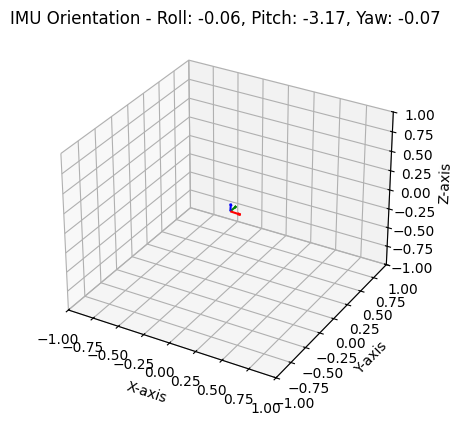

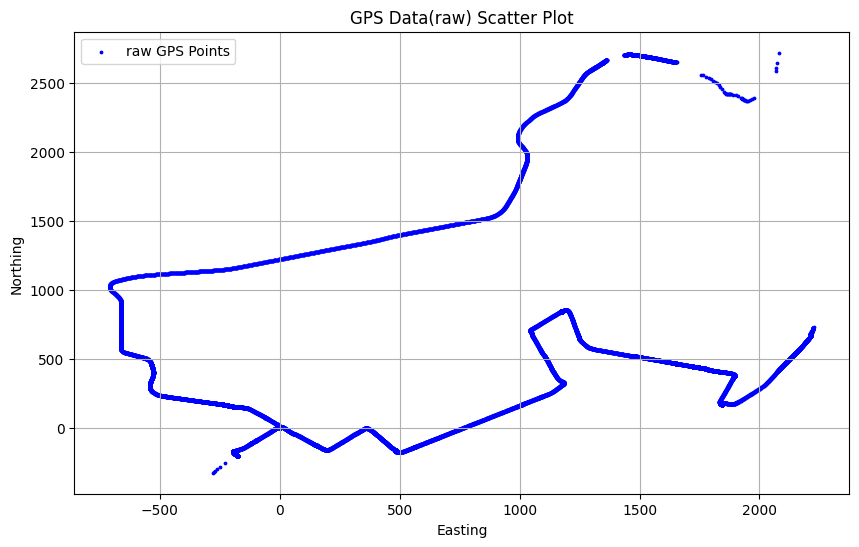

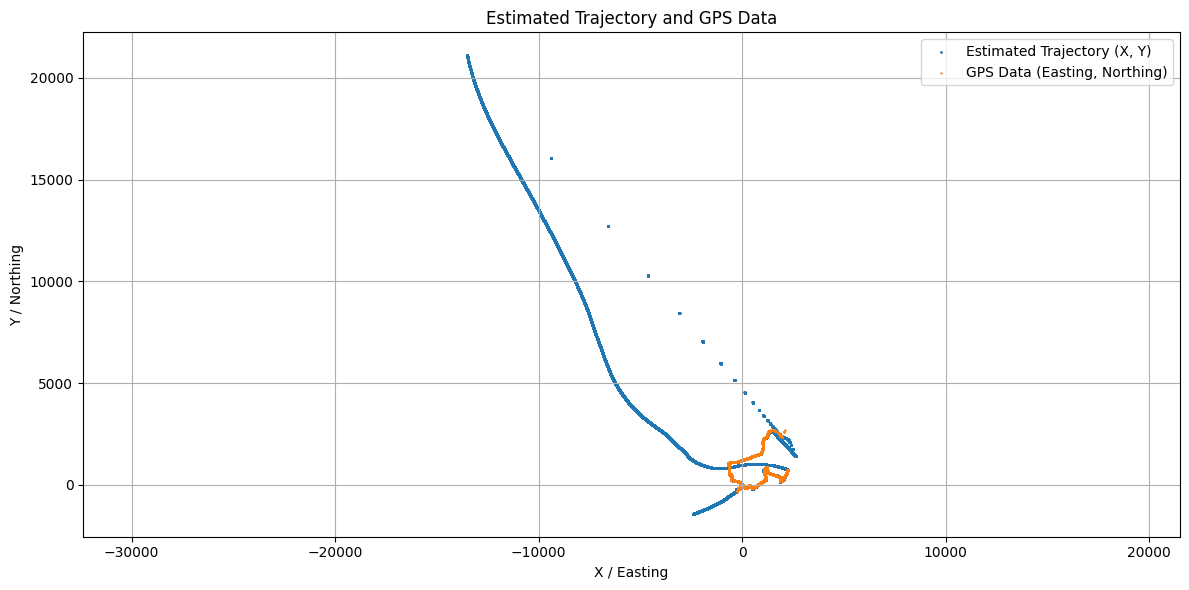

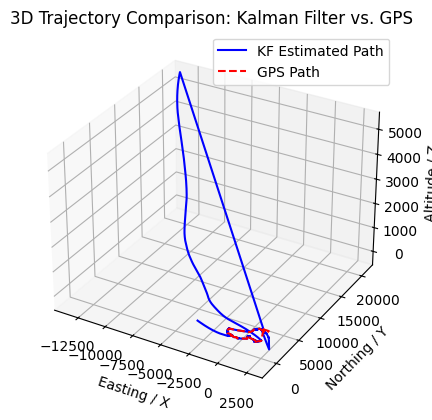

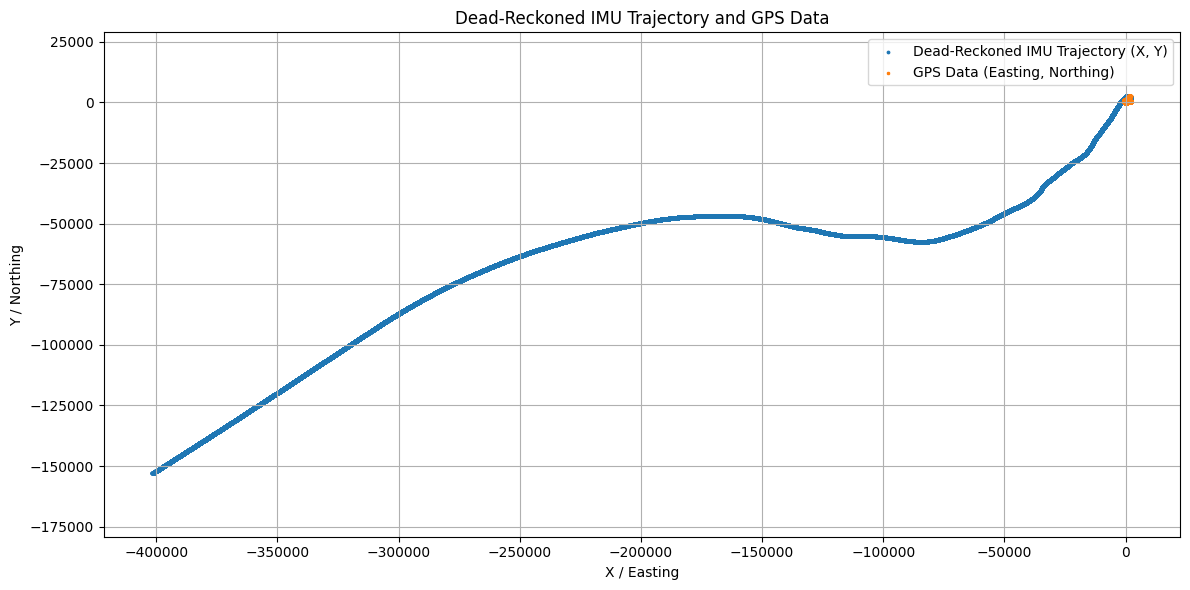

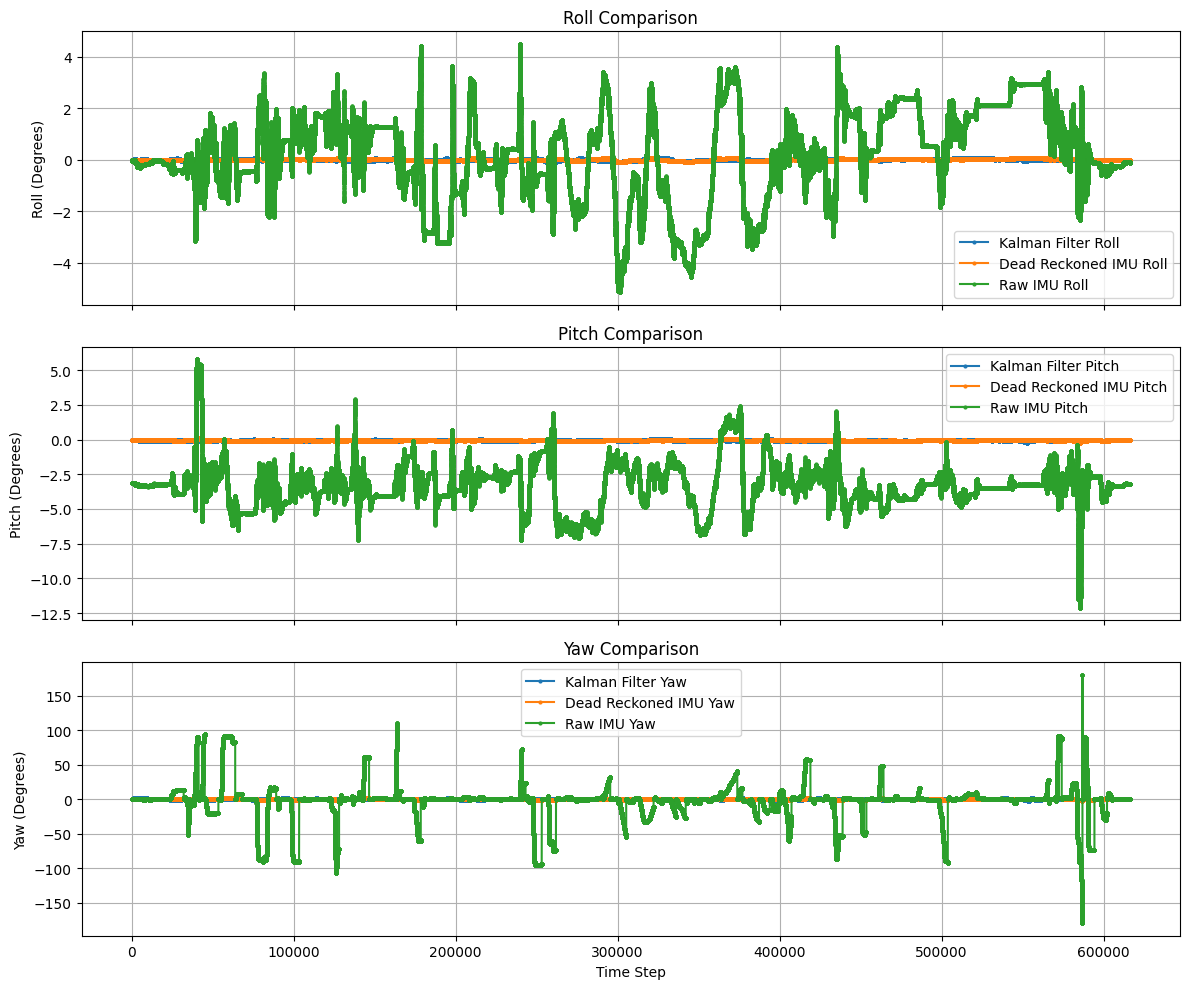

In [ ]:
# Plot the IMU frame with average orientation
sensor_fusion.plot_imu_frame(avg_roll, avg_pitch, avg_yaw)

# Plot raw GPS data
sensor_fusion.plot_gps_data()

# Plot the estimated states from the Kalman filter against GPS data
sensor_fusion.plot_kf_states_2d(sf_KF_state)
sensor_fusion.plot_kf_states_3d(sf_KF_state)

# Plot dead-reckoned IMU estimates against raw GPS data
sensor_fusion.plot_deadreckoned_imu_with_gps_2d(deadreckoned_IMU_estimates)

# Plot theta comparisons
sensor_fusion.plot_theta_comparisons(sf_KF_state, deadreckoned_IMU_estimates)


# Dynamic Visualizations

In [ ]:
sensor_fusion.animate_kf_states_2d(sf_KF_state, save_path='kf_animation.mp4') # ~4.5 min execution time with skip_rate=200

When examining the combined GPS and IMU data fused through the Kalman Filter, the results closely mirrored the raw GPS data whenever GPS was available. This accuracy was evident in the initial plot. However, a noticeable drift occurred during periods like tunnel passages where GPS data was unavailable, illustrating the limitations of relying solely on IMU data in such scenarios.

In the second graph, I compared the pure IMU-based dead reckoning against the raw GPS ground truth data. This comparison starkly highlighted the inability of the IMU data alone to accurately estimate the vehicle's state. The IMU-based estimates were significantly off-track compared to the GPS data, confirming the essential role of GPS for reliable pose estimation.

The third plot brought an interesting perspective by comparing the theta estimates obtained through both methods. This comparison further reinforced the findings from the previous graphs, showing how the integration of GPS data with IMU readings through a Kalman Filter provides a more reliable and accurate estimation of the vehicle's orientation and movement, especially in comparison to using IMU data alone.

In my experience with the Kalman Filter during this project, its performance was highly dependent on the availability and quality of GPS data. When GPS data was accessible, the filter effectively tracked the state changes, aligning closely with the GPS data. However, in scenarios where the GPS signal was lost, the filter had to rely on IMU-based dead reckoning, which quickly became inaccurate. This issue could be attributed to the limitations in our bias and noise models, which were simplified and not fully representative of real-world dynamics.
